In [10]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append('../src')

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20,10

## Testing the Marcenko-Pastur Theorem

All the procedures are defined in the src.data.clean package.

In [11]:
from src.data.clean import *

/Users/aennassiri/anaconda3/envs/Research/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
x = np.random.normal(size=(10000, 1000))
eval0, _ = get_pca(np.corrcoef(x, rowvar=False))
mp = MarcenkoPastur(points=1000)
pdf0 = mp.pdf(var=1., q=x.shape[0]/float(x.shape[1]))
pdf1 = fit_kde(np.diag(eval0), bandwidth=0.01, x=pdf0.index.values.reshape(-1, 1))

Text(0.5, 1.0, 'A visualization of the Marcenko-Pastur Theorem')

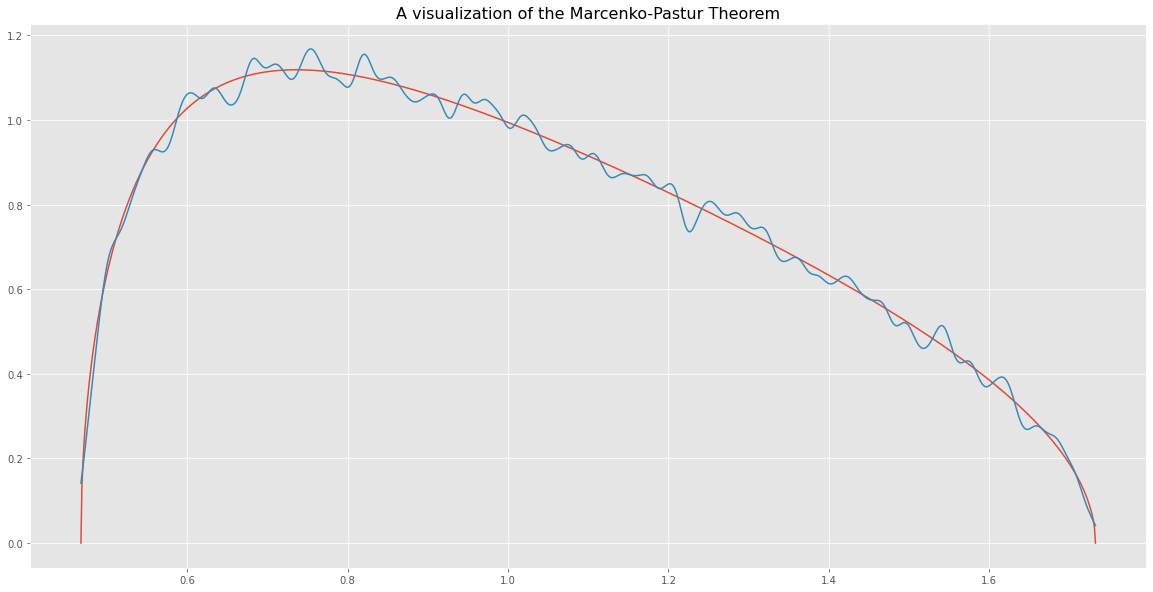

In [13]:
plt.plot(pdf0.index.values, pdf0)
plt.plot(pdf0.index.values, pdf1)
plt.title('A visualization of the Marcenko-Pastur Theorem', fontsize=16)

### Comments:

## Fitting the Marcenko-Pastur Distribution

In [14]:
from src.testing.fixtures import CorrelationFactory

alpha = 0.995
columns_number = 1000
facts_number = 100
q = 10

cf = CorrelationFactory(n_cols=columns_number)

covariance = np.cov(np.random.normal(size=(columns_number*q, columns_number)), rowvar=False)
covariance = alpha*covariance + (1-alpha)*cf.get_rnd_covariance(facts_number=facts_number)

corr0 = cf.cov2corr(covariance)
eval0, evec0 = get_pca(corr0)

mp = MarcenkoPastur()
emax0, var0 = mp.fit(np.diag(eval0), q, bandwidth=0.01)
facts_number0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

This method helps us discriminate between eigenvalues associated with noise components and eigenvalues associated
with signal components.

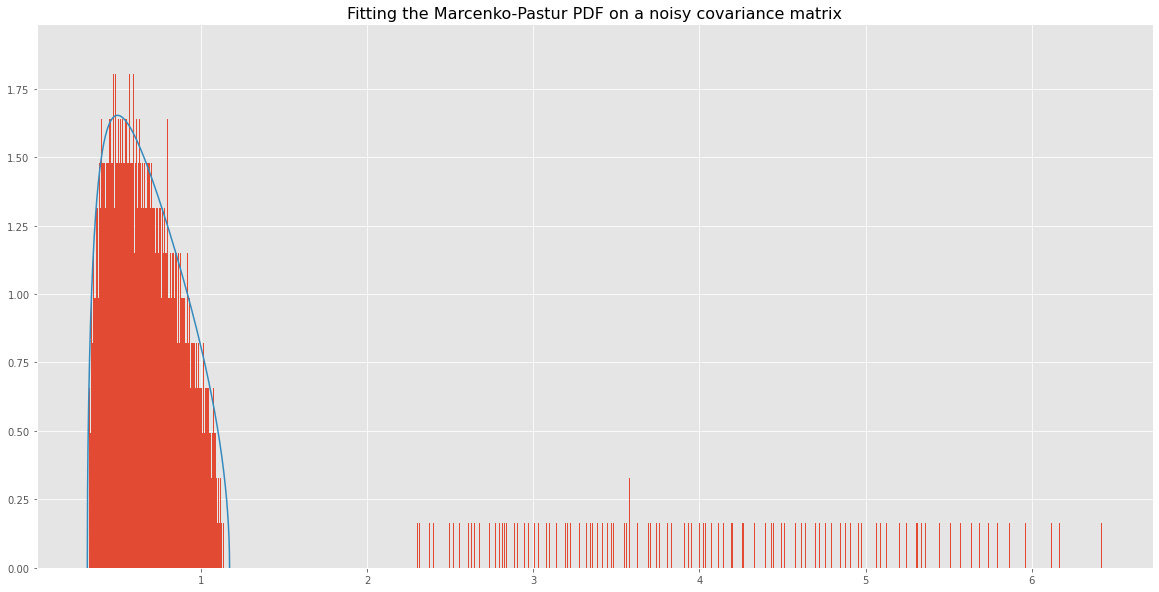

In [15]:
pdf0 = mp.pdf(var=var0, q=q)
nn, bb, patches=plt.hist(eval0.diagonal(),
                         bins=1000,
                         density=True)
plt.plot(pdf0.index.values, pdf0)
plt.title('Fitting the Marcenko-Pastur PDF on a noisy covariance matrix', fontsize=16)

plt.ylim(top=nn[1:].max() * 1.1)
plt.show()

## Denoising

### Denoising with the constant residual eigen value method

In [16]:
# Reusing the same results from before
corr = mp.denoise(eval0, evec0)
eval1, evec1 = get_pca(corr)

Text(0.5, 1.0, 'A visualization of the Marcenko-Pastur Theorem')

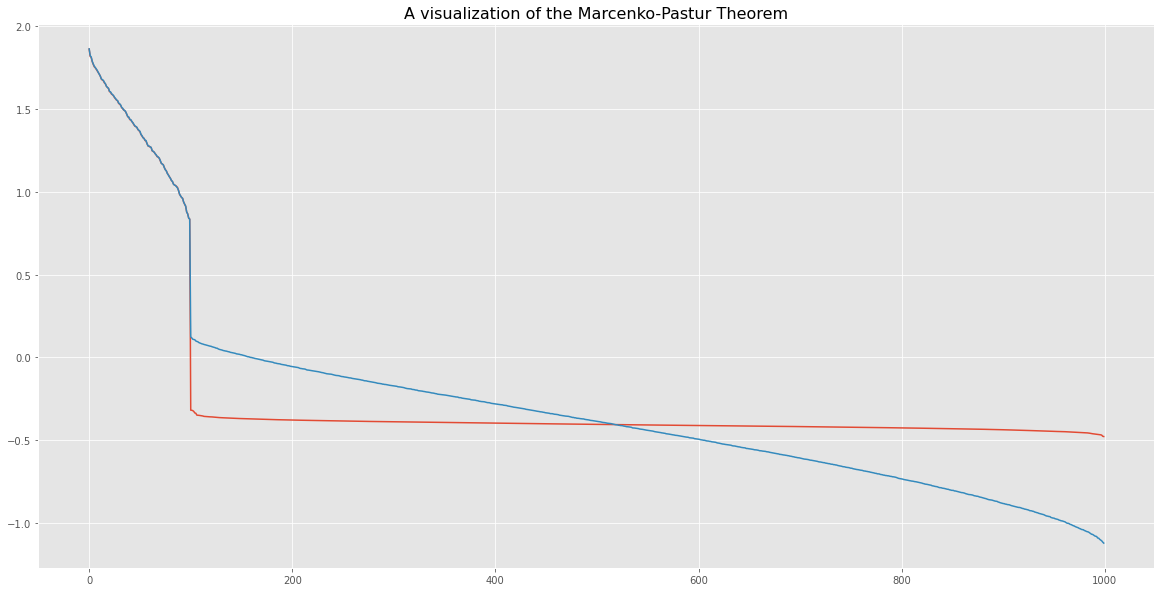

In [17]:
plt.plot(np.log(eval1.diagonal()))
plt.plot(np.log(eval0.diagonal()))


plt.title('A visualization of the Marcenko-Pastur Theorem', fontsize=16)


### Denoising with the shrinkage method

Text(0.5, 1.0, 'A visualization of the Marcenko-Pastur Theorem')

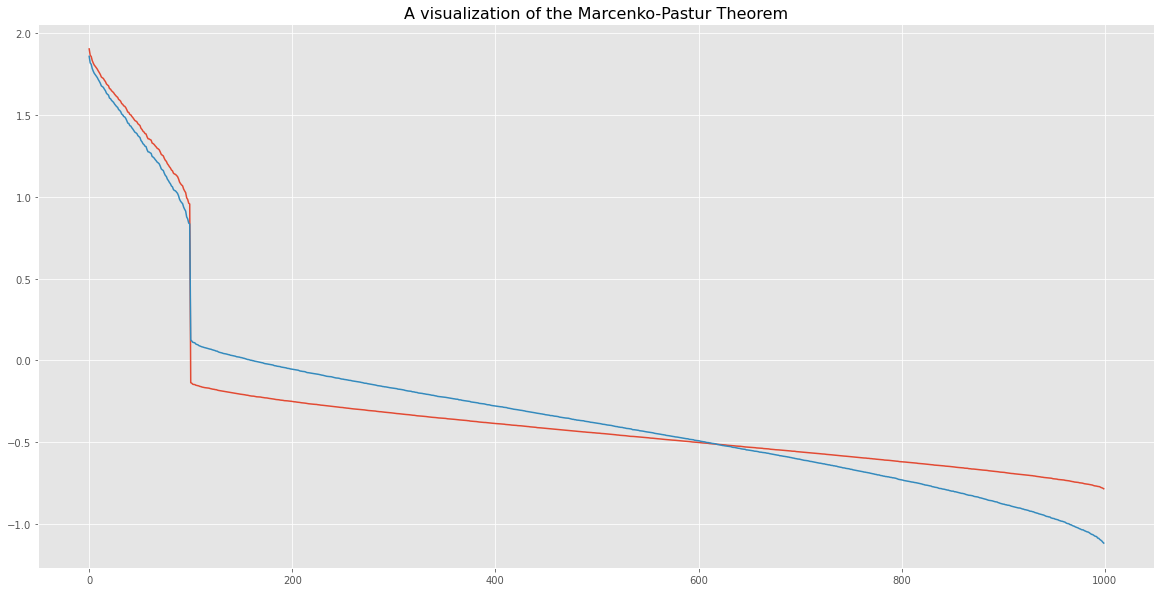

In [18]:
corr = mp.denoise(eval0, evec0, method="shrink", alpha=0.5)
eval2, evec2 = get_pca(corr)

plt.plot(np.log(eval2.diagonal()))
plt.plot(np.log(eval0.diagonal()))
plt.title('A visualization of the Marcenko-Pastur Theorem', fontsize=16)

## Experimental Results

In the experimental results, we estimate a minimum variance portfolio with and without denoising
then compare it with the true covariance matrix.

In [19]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

from src.utils import corr2cov, cov2corr

def form_block_matrix(n_blocks, b_size, b_corr):
    """
    Form a block matrix of size b_size and correlation b_corr

    :param n_blocks: Number of blocks
    :type n_blocks: int
    :param b_size: Size of the blocks
    :type b_size: int
    :param b_corr: Correlation
    :type b_corr: float
    :return: A matrix of size (n_blocks*b_size, n_blocks*b_size)
    :rtype: np.ndarray
    """
    block = np.ones((b_size, b_size)) * b_corr
    block[range(b_size), range(b_size)] = 1 
    corr = block_diag(*([block]*n_blocks))
    return corr 


def form_true_matrix(n_blocks, b_size, b_corr):
    """
    Form the true covariance matrix

    :param n_blocks:
    :type n_blocks:
    :param b_size:
    :type b_size:
    :param b_corr:
    :type b_corr:
    :return:
    :rtype:
    """
    corr0 = form_block_matrix(n_blocks=n_blocks, b_size=b_size, b_corr=b_corr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1)
    return mu0, cov0

def sim_cov_mu(mu0, cov0, n_obs, shrink=False):
    """
    Simulates a random matrix X of size n_obs * len(cov0) from a covariance matrix
    If shrink = True, the function fperforms a Ledoit-Wolf shrinkage of the
    empirical covariance matrix

    :param mu0: Vector of means
    :type mu0: np.ndarray
    :param cov0: Covariance matrix
    :type cov0: np.ndarray
    :param n_obs: Number of observations to simulate
    :type n_obs: int
    :param shrink: Shrink or not
    :type shrink: bool
    :return:
    :rtype:
    """
    X = np.random.multivariate_normal(mu0.flatten(), cov0, size=n_obs)
    mu1 = X.mean(axis=0).reshape(-1, 1)
    if shrink:
        cov1 = LedoitWolf().fit(X).covariance_
    else:
        cov1 = np.cov(X, rowvar=0)
    return mu1, cov1

def denoise_cov(cov0, q, bandwidth):
    corr0 = cov2corr(cov0)
    eval0, evec0 = get_pca(corr0)
    mp = MarcenkoPastur()
    mp.fit(eigenvalues=np.diag(eval0), q=q, bandwidth=bandwidth)
    corr1 = mp.denoise(eigenvalues=eval0, eigenvectors=evec0)
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

def opt_port(cov, mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    if mu is None:
        mu = ones
    w = inv @ mu
    w /= ones.T @ w
    return w

In [20]:
n_blocks = 10
b_size = 50 
b_corr = 0.5

mu0, cov0 = form_true_matrix(n_blocks=n_blocks, b_size=b_size, b_corr=b_corr)

In [21]:
n_obs = 1000
n_trials = 1000
bandwidth = .01
shrink = False
min_var_portfolio = True


w1 = pd.DataFrame(columns=range(cov0.shape[0]),
                  index=range(n_trials))

w1_d = w1.copy(deep=True)

np.random.seed(0)

for i in range(n_trials):
    mu1, cov1 = sim_cov_mu(mu0=mu0, cov0=cov0, n_obs=n_obs, shrink=shrink)
    if min_var_portfolio:
        mu1 = None

    cov1_d = denoise_cov(cov0=cov1, q=n_obs*1./cov1.shape[1], bandwidth=bandwidth)
    w1.loc[i] = opt_port(cov1, mu1).flatten()
    w1_d.loc[i] = opt_port(cov1_d, mu1).flatten()


### Results Evaluation
After computing the true minimum variance portfolio drived from the true covariance matrix,
we compute the root-mean-squre errors (RMSE) with and without denoising.

In [24]:
w0 = opt_port(cov0, None if min_var_portfolio else mu0) # True minimum var portfolio
w0 = np.repeat(w0.T, w1.shape[0], axis=0)

rmse = np.mean((w1-w0).values.flatten()**2)**.5
rmse_denoised = np.mean((w1_d-w0).values.flatten()**2)**.5
print(f"RMSE = {rmse:e} / RMSE denoised {rmse_denoised:e}")


RMSE = 5.005367e-03 / RMSE denoised 1.164071e-03


## Exercises

1. Implement in python the detoning method described in Section2.6.